<center>
<div class="alert alert-block alert-info">
<h1>Data Analysis</h1>
    </div>

<a id=menu></a>
## Menu

* [Imports](#imports)
* [Add Customers with Unknown ID](#add_nans)
 
* [Most Popular Product](#sales_investigate)
* [Monthly Sales](#monthly_sales)

<a id=imports></a>
## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from datetime import datetime
import os

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#data path to csv file
data_path = '../cleaned_data'
file_path = '/clean_sales_df.csv'

In [4]:
#import data
data = pd.read_csv(data_path+file_path, index_col = 0,parse_dates = ['InvoiceDate'])
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [5]:
data.shape

(770386, 17)

<a id=add_nans></a>
### Add Customers with Nan ID
>Import the dataframe with guest customers, who have no ID and add it to my dataframe, because all I care about are the sales 

In [6]:
#load data for unknown customers
nan_customers = pd.read_csv(data_path + '/nan_customers.csv',index_col=0,parse_dates = ['InvoiceDate'])
nan_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,2009-12-01 00:00:00,0.55,2009,12,1,4,49,1,335
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,2009-12-01 00:00:00,0.85,2009,12,1,4,49,1,335
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,2.95,2009,12,1,4,49,1,335
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,2009-12-01 00:00:00,15.00,2009,12,1,4,49,1,335
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,8.85,2009,12,1,4,49,1,335


In [7]:
#making sure customer id is all nans
nan_customers.shape[0], nan_customers['Customer ID'].isna().sum()

(226860, 226860)

In [8]:
#merge data and nan_customers dataframes
df = pd.concat([data, nan_customers],axis=0)
print(df.shape)
df.head(2)

(997246, 17)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [11]:
#rename revenue to sales for ease of use
df.rename(columns={'Revenue':'Sales'},inplace=True)
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [9]:
#drop products with no description
df = df[df['Description'].notna()]
#any weird description
(pd.Series(df['Description'].unique()).apply(lambda x: len(x))<2).sum()

0

In [ ]:
#save df with all customers
df.to_csv('../cleaned_data/data_with_all_customer_ids.csv')

In [3]:
df=pd.read_csv("../cleaned_data/data_with_all_customer_ids.csv")

<a id=sales_investigate></a>
### Investigate Product Sales
>One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

>The date is one of the important factors influencing sales and it acts as an independent variable. To put it simply, this is a time-series data i.e a series of data points ordered in time.

In [85]:
#The top 10 most lucrative products
imp_prod = df.groupby('StockCode')['Sales'].sum().sort_values(ascending=False).reset_index()[:10]
imp_prod

,StockCode,Sales
0,22423,321761.92
1,85123A,249074.21
2,85099B,179049.21
3,47566,147460.58
4,84879,128653.51
5,22086,116666.54
6,79321,80082.58
7,22197,79344.75
8,22386,75542.07
9,20725,70280.64


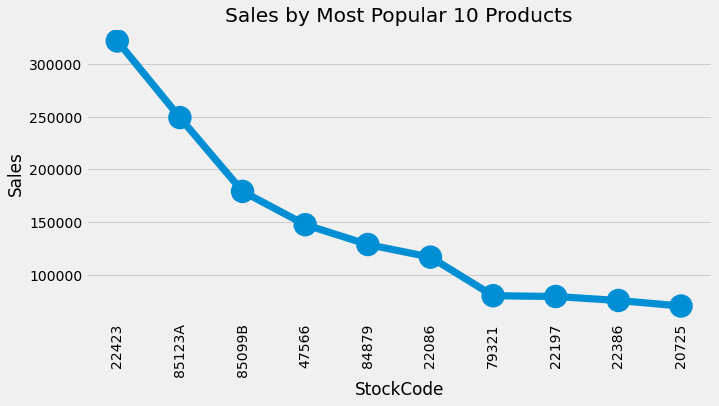

In [13]:
#plot the 10 most lurative products
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
sns.pointplot( x='StockCode',y='Sales',data=imp_prod)
plt.xticks(rotation=90)
plt.title('Sales by Most Popular 10 Products')
plt.show()

In [86]:
#most sold 10 products
prod_list = []
for product in imp_prod.StockCode:
    p = df.Description[df['StockCode']==product].unique().tolist()[0]
    prod_list.append(p)
    
imp_prod['product']=prod_list

In [91]:
imp_prod['%of_total_sales'] = np.round(imp_prod.Sales/df.Sales.sum() *100,2)
imp_prod

,StockCode,Sales,product,%of_total_sales
0,22423,321761.92,REGENCY CAKESTAND 3 TIER,1.68
1,85123A,249074.21,WHITE HANGING HEART T-LIGHT HOLDER,1.30
2,85099B,179049.21,JUMBO BAG RED WHITE SPOTTY,0.94
3,47566,147460.58,PARTY BUNTING,0.77
4,84879,128653.51,ASSORTED COLOUR BIRD ORNAMENT,0.67
5,22086,116666.54,PAPER CHAIN KIT 50'S CHRISTMAS,0.61
6,79321,80082.58,CHILLI LIGHTS,0.42
7,22197,79344.75,"POPCORN HOLDER , SMALL",0.42
8,22386,75542.07,JUMBO BAG PINK WITH WHITE SPOTS,0.40
9,20725,70280.64,LUNCH BAG RED SPOTTY,0.37


The most popular product is a regency cakestand which accounts for almost 2% of the company's total sales over two years.
Next let's explore how sales look like on a monthly basis for each year

[Back to Index](#menu)
<a id='monthly_sales'></a>
### Monthly Sales Quantity

In [106]:
#create a dataframe of sum monthly dollar sales and replace month number by month name 
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

#create a dataframe for monthly total sales by year and month
sales_monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
#sales_monthly = df.groupby(['Year','Month'])['Quantity'].sum().reset_index()

sales_monthly['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly['Month_name'] = sales_monthly.Month.map(month_dict)

#create a dataframe of average monthly dollar sales 
sales_monthly_avg = df.groupby(['Year','Month'])['Sales'].mean().reset_index()
#sales_monthly_avg = df.groupby(['Year','Month'])['Quantity'].mean().reset_index()

sales_monthly_avg['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly_avg['Month_name'] = sales_monthly.Month.map(month_dict)

#create a dataframe of sum monthly quantity 
quantity_monthly_sum = df.groupby(['Year','Month'])['Quantity'].sum().reset_index()
quantity_monthly_sum['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
quantity_monthly_sum['Month_name'] = sales_monthly.Month.map(month_dict)

In [110]:
sales_monthly

,Year,Month,Sales,Monthly,Month_name
0,2009,12,786735.150,2009-12-01,Dec
1,2010,1,604774.302,2010-01-01,Jan
2,2010,2,527974.395,2010-02-01,Feb
3,2010,3,753318.601,2010-03-01,Mar
4,2010,4,628507.432,2010-04-01,Apr
5,2010,5,627837.080,2010-05-01,May
6,2010,6,685507.790,2010-06-01,Jun
7,2010,7,618798.400,2010-07-01,Jul
8,2010,8,655599.130,2010-08-01,Aug
9,2010,9,854539.991,2010-09-01,Sep


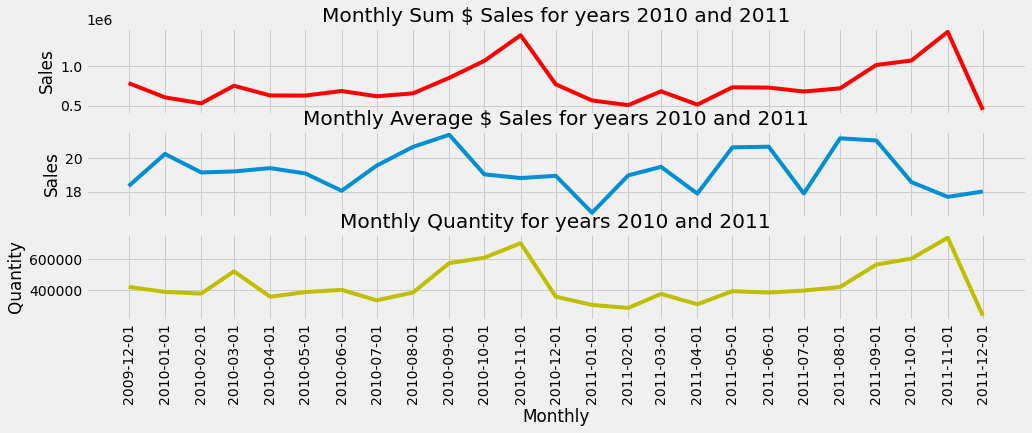

In [111]:
#plot monthly sales trend
x_ticks = sales_monthly_avg['Monthly'].dt.date
f,ax = plt.subplots(3,1,figsize=(15,5),sharex=True)

sns.lineplot(data=sales_monthly,x='Monthly',y='Sales',ax=ax[0],color='red')
ax[0].set_title('Monthly Sum $ Sales for years 2010 and 2011')

sns.lineplot(data=sales_monthly_avg,x='Monthly',y='Sales',ax=ax[1])
ax[1].set_title('Monthly Average $ Sales for years 2010 and 2011')

sns.lineplot(data=quantity_monthly_sum,x='Monthly',y='Quantity',ax=ax[2],color='y')
ax[2].set_title('Monthly Quantity for years 2010 and 2011')

plt.xticks(x_ticks,rotation=90);

### Observations
- In September 2010 there is a spike in average sales which then goes down but in sum of sales continues to rise, which means that the number of orders continues to increase of products of similar value. 

- In November there is a spike in sum of sales, which is probably the Christmas rush which starts slowing down in December, meaning that most people buy their gifts in November. Since this is an online store it makes sense that people would order gifts early so that they arrive on time. It is interesting to note that in November sum of sales goes up while average sales goes down, which means that there are many small orders. 

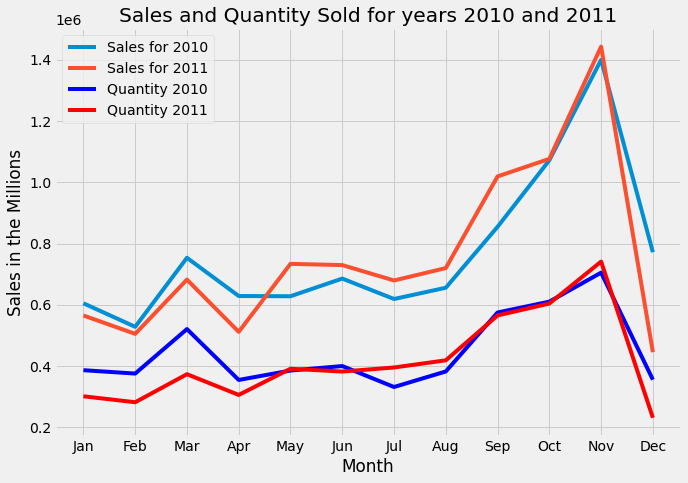

In [117]:
#compare sales for years 2010 and 2011
plt.figure(figsize=(10,7))
sns.lineplot(data=sales_monthly[sales_monthly.Year==2010],x='Month_name',y='Sales',label='Sales for 2010')
sns.lineplot(data=sales_monthly[sales_monthly.Year==2011],x='Month_name',y='Sales',label='Sales for 2011')
sns.lineplot(data=quantity_monthly_sum[quantity_monthly_sum.Year==2010],x='Month_name',y='Quantity',label='Quantity 2010',color='blue')
sns.lineplot(data=quantity_monthly_sum[quantity_monthly_sum.Year==2011],x='Month_name',y='Quantity',label='Quantity 2011',color='red')

plt.xlabel('Month')
plt.ylabel('Sales in the Millions')
plt.title('Sales and Quantity Sold for years 2010 and 2011');


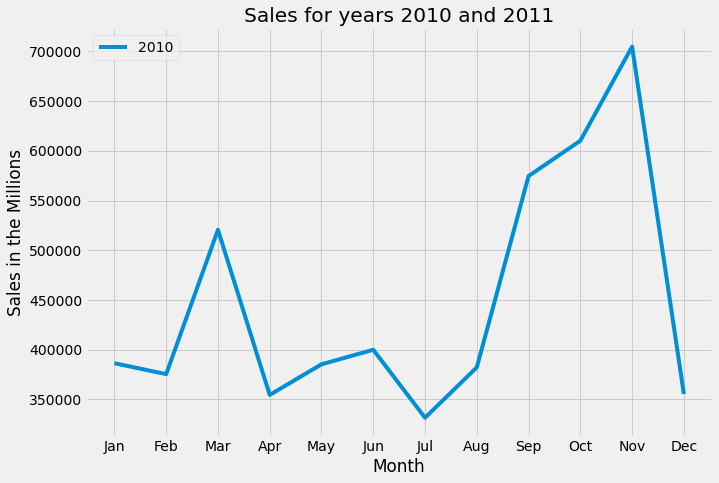

In [121]:
plt.figure(figsize=(10,7))
sns.lineplot(data=quantity_monthly_sum[sales_monthly.Year==2010],x='Month_name',y='Quantity',label=2010)
#sns.lineplot(data=sales_monthly[sales_monthly.Year==2011],x='Month_name',y='Quantity',label=2011)
plt.xlabel('Month')
plt.ylabel('Sales in the Millions')
plt.title('Sales for years 2010 and 2011');

- Both years follow the same sales trend with a noticeable increase in sales starting in August until November  for Christmas in both years, and this might affect our predictions, so I might separate the sales data into sales before Christmas and sale after. 

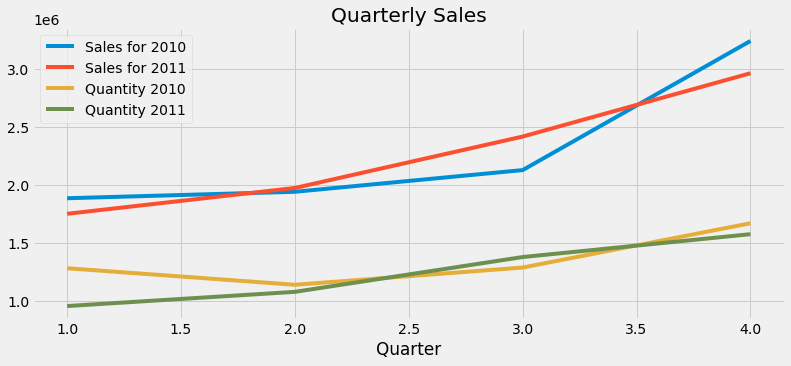

In [97]:
#Compare quarterly sales and quarterly quantity 
plt.figure(figsize=(12,5))
df[df.Year==2010].groupby('Quarter')['Sales'].sum().plot(label='Sales for 2010')
df[df.Year==2011].groupby('Quarter')['Sales'].sum().plot(label='Sales for 2011')
df[df.Year==2010].groupby('Quarter')['Quantity'].sum().plot(label='Quantity 2010')
df[df.Year==2011].groupby('Quarter')['Quantity'].sum().plot(label='Quantity 2011')

plt.legend()
plt.title('Quarterly Sales');

- For sales and for the quantity ordered there is an increase in last quarter, this is because of the increased sales for Christmas

In [99]:
#How do sales vary for weekdays and weekends
#look at daily sum of sales
day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thr',4:'Fri',5:'Sat',6:'Sun'}
daily_sum = df.groupby('Week_day')['Sales'].sum().reset_index()
daily_avg = df.groupby('Week_day')['Sales'].mean().reset_index()

daily_sum['Week_day']=daily_sum.Week_day.map(day_dict)
daily_avg['Week_day']=daily_avg.Week_day.map(day_dict)
daily_sum 

,Week_day,Sales
0,Mon,3.362902e+06
1,Tue,3.746286e+06
2,Wed,3.344161e+06
3,Thr,3.924036e+06
4,Fri,2.944734e+06
5,Sat,9.518430e+03
6,Sun,1.764030e+06


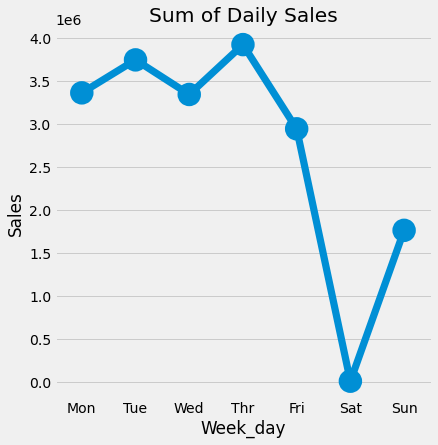

In [100]:
#weekdays and weekends sales plot
sns.factorplot(data=daily_sum,x='Week_day',y='Sales',size=6, aspect=1)

plt.title('Sum of Daily Sales');

- Sales seem to decrease on Saturday, which makes sense, since this data is for an online store people make their orders on Sunday and almost no orders on Saturday.

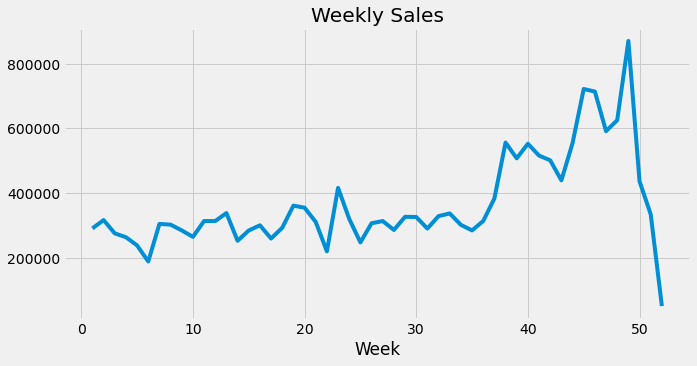

In [101]:
#how aboout sales for the week 
plt.figure(figsize=(10,5))

df.groupby('Week')['Sales'].sum().plot()
plt.title('Weekly Sales');

- Again sales increase by end of year for Christmas season

In [5]:
yearly_avg = df[df.Year>2009].groupby('Year')['Sales'].mean()
yearly_sum = df[df.Year>2009].groupby('Year')['Sales'].sum()
'${:,.2f}'.format(yearly_avg),yearly_sum

TypeError: unsupported format string passed to Series.__format__

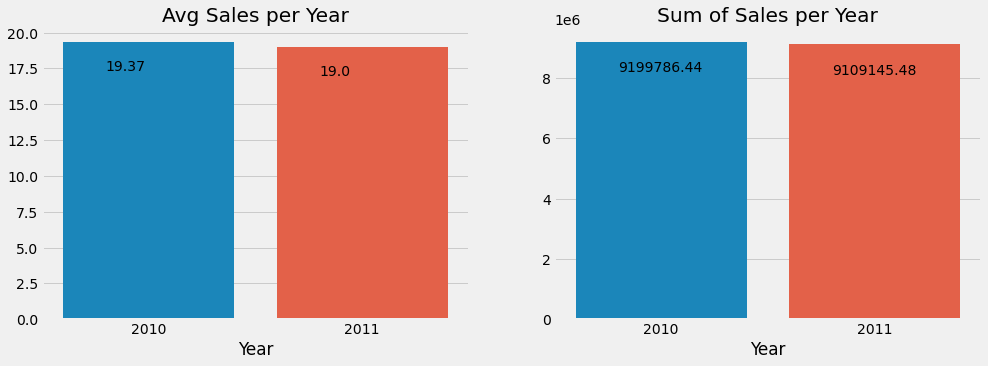

In [175]:
#So what is the average sales for years 2009 and 2010
yearly_avg = df[df.Year>2009].groupby('Year')['Sales'].mean()
yearly_sum = df[df.Year>2009].groupby('Year')['Sales'].sum()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
p = sns.barplot(x=yearly_avg.index, y=np.round(yearly_avg.values,2))
for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-2))
plt.title('Avg Sales per Year')

plt.subplot(1,2,2)
p = sns.barplot(x=yearly_sum.index, y=np.round(yearly_sum.values,2))
for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-1e6))

plt.title('Sum of Sales per Year');

- There is a slight decrease in average and sum of sales from 2010 to 2011, which could mean that there is less orders being made. I will investigate the number of orders per year

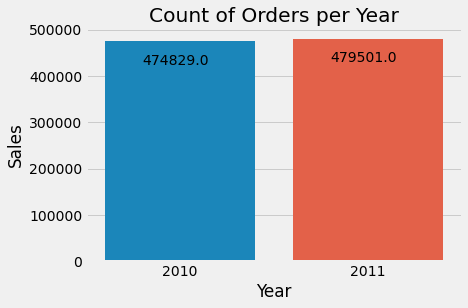

In [159]:
#so lets investigate the number of orders per year
yearly_count = df[df.Year>2009].groupby('Year')['Sales'].count().reset_index()
#yearly_sum = data[data.Year>2009].groupby('Year')['Sales'].sum()
p = sns.barplot(x=yearly_count.Year, y=yearly_count.Sales)
for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-50000))

plt.title('Count of Orders per Year');


- The number of orders increased but the sum decreased from year 2010 to 2011. This could mean the cheaper products have become more popular and people are ordering them so more orders but the company is making less in sales  